# ポアソン混合モデル 変分推論

「ベイズ推論による機械学習入門」p.128~を参照．

こちらも参考になる．  
http://machine-learning.hatenablog.com/entry/2016/07/06/200605

参考にしたコードはこちら  
https://github.com/sammy-suyama/MLBlog/blob/master/src/PMM.jl

In [1]:
!date

2019年 8月27日 火曜日 14時48分13秒 JST


In [2]:
%matplotlib inline
%matplotlib nbagg

import warnings
from copy import deepcopy

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from scipy.special import logsumexp, digamma

from matplotlib.animation import ArtistAnimation
from IPython.display import HTML, display

warnings.filterwarnings('ignore')
plt.style.use('seaborn-darkgrid')
plt.rcParams['image.cmap'] = 'viridis'
sns.set_context('talk')

# ポアソン混合分布

In [3]:
class PoissonMixture:
    """
    Poisson Mixture model

    p(x, z, lmd, pi) = p(x|z, lmd)p(z|pi)p(lmd)p(pi)
    
    p(pi) = Dir(pi|alpha)
    p(lmd) = Gam(lmd_d,k|a, b)
    p(z|pi) = Cat(z_n|pi)
    p(x|z, lmd) = Poi(x_n,d|lmd_d,k)^(z_n,k)
    """
    
    def __init__(self, d=2, k=3, alpha=[10., 10., 10.], 
                 a=[[1., 1., 1.], [1., 1., 1.]], b=[1., 1., 1.]):
        
        if k != len(alpha):
            raise 'Category and dim should be same'
        
        # Dimension
        self.d = d
        self.k = k
        
        # Hyper parameters
        self.alpha = np.array(alpha)
        self.a = np.array(a)
        self.b = np.array(b)
        
        # Paramters
        self.pi = None
        self.lmd = None
        
        # Latent variable
        self.z = None
        
    def sample_data(self, sample_num=10):
        self.pi = np.random.dirichlet(self.alpha)
        self.lmd = np.random.gamma(self.a, 1 / self.b)
        self.z = np.array([np.random.choice(self.k, p=self.pi) for _ in range(sample_num)])
        x = np.array([[np.random.poisson(self.lmd[d, self.z[n]]) for d in range(self.d)] 
                      for n in range(sample_num)])

        return x, self.z

# 人口データのシミュレート

In [4]:
# Model
D = 2
K = 4
alpha = 100.0 * np.ones(K)
a = np.ones((D, K), dtype=float)
b = 0.01 * np.ones(K, dtype=float)
dist = PoissonMixture(D, K, alpha, a, b)

#### 潜在変数の持つ値で色分けをしている．

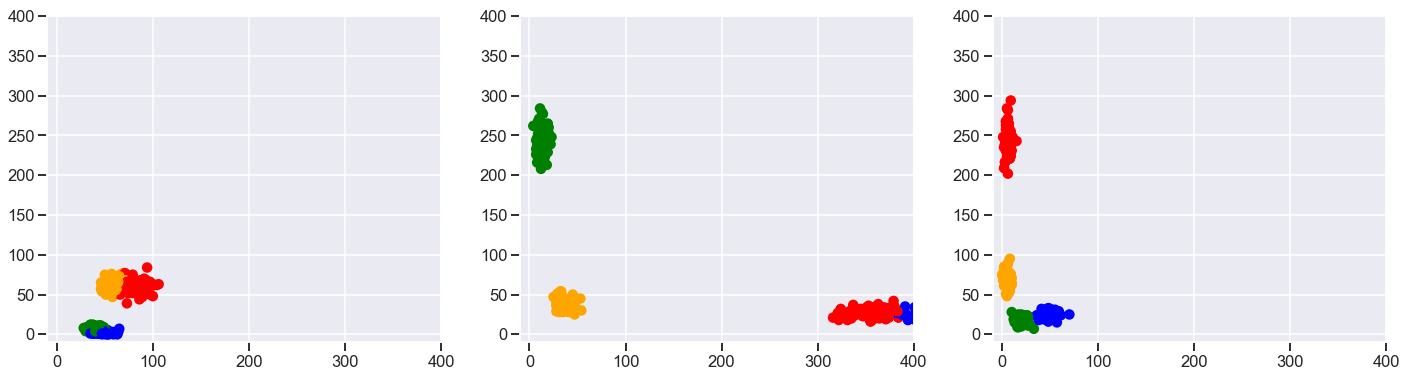

In [5]:
N = 300
colors = np.array(['b', 'r', 'g', 'orange'])
plt.figure(figsize=(24, 6))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    data, z = dist.sample_data(N)

    # Plot
    plt.scatter(data[:, 0], data[:, 1], color=colors[z])
    plt.xlim([-10, 400])
    plt.ylim([-10, 400])
plt.show()

# Variational Inference

In [6]:
class PMMVI(PoissonMixture):
    def __init__(self, d=2, k=3, alpha=[10., 10., 10.], 
                 a=[[1., 1., 1.], [1., 1., 1.]], b=[1., 1., 1.]):
        super().__init__(d, k, alpha, a, b)
        
    def inference(self, x, max_iter=50):
        N = len(x)
        ret = np.zeros((max_iter, N), dtype=np.int32)
        
        # Initialize q(pi), q(lambda)
        lmd_expt = self.a / self.b
        ln_lmd_expt = digamma(self.a) - np.log(self.b)
        ln_pi_expt = digamma(self.alpha) - digamma(np.sum(self.alpha))
        
        for i in range(max_iter):
            # Update z
            ln_eta = np.array([[np.sum(x[n] * ln_lmd_expt[:, k] - lmd_expt[:, k]) + ln_pi_expt[k]
                                for k in range(self.k)]
                               for n in range(N)])
            ln_eta -= logsumexp(ln_eta, axis=1)[:, None]
            z_expt = np.exp(ln_eta)
            
            # Argmax z
            self.z = np.argmax(z_expt, axis=1)
            ret[i] = self.z
            
            # Update lambda
            self.a += np.array([[np.sum(x[:, d] * z_expt[:, k])
                                 for k in range(self.k)]
                                for d in range(self.d)])
            self.b += np.sum(z_expt, axis=0)
            lmd_expt = self.a / self.b
            ln_lmd_expt = digamma(self.a) - np.log(self.b)

            # Update pi
            self.alpha += np.sum(z_expt, axis=0)
            ln_pi_expt = digamma(self.alpha) - digamma(np.sum(self.alpha))
            
        return ret

# 2-カテゴリ・データに対する推論

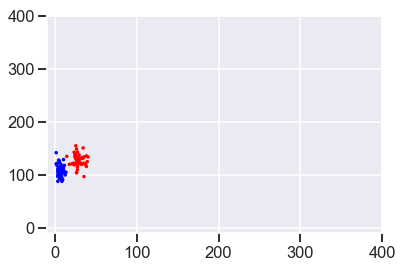

In [7]:
D = 2
K = 2
alpha = 100.0 * np.ones(K)
a = np.ones((D, K), dtype=float)
b = 0.01 * np.ones(K, dtype=float)
N = 100

dist = PoissonMixture(D, K, alpha, a, b)
x_gen, z_gen = dist.sample_data(N)

# Plot
colors = np.array(['b', 'r', 'g', 'orange'])
plt.scatter(x_gen[:, 0], x_gen[:, 1], color=colors[z_gen], s=4)
plt.xlim([-10, 400])
plt.ylim([-10, 400])
plt.show()

### 推論アニメーション

In [8]:
MAX_ITER = 50
model = PMMVI(D, K, alpha, a, b)
z_pred = model.inference(x_gen, max_iter=MAX_ITER)

# Plot
colors = ['b', 'r', 'g', 'orange']
frames = []
fig, ax = plt.subplots()
ax.set_xlim([-10, 400])
ax.set_ylim([-10, 400])
for i in range(MAX_ITER):
    im = []
    for k in range(K):
        mask = z_pred[i] == k
        im_ = ax.plot(x_gen[mask, 0], x_gen[mask, 1], 'o', c=colors[k], markersize=4)
        im += im_
    frames.append(im)
    
plt.close()

In [9]:
ani = ArtistAnimation(fig, frames)
HTML(ani.to_jshtml())

In [10]:
print('Distribution lambda:\n', dist.lmd)
print('Estimated lambda:\n', model.lmd)

Distribution lambda:
 [[  6.65446702  28.82848973]
 [110.08669156 127.59817576]]
Estimated lambda:
 None


# 4-カテゴリ・データに対する推論

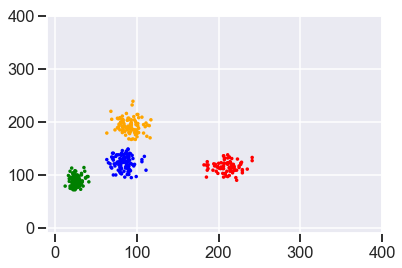

In [11]:
D = 2
K = 4
alpha = 100.0 * np.ones(K)
a = np.ones((D, K), dtype=float)
b = 0.01 * np.ones(K, dtype=float)
N = 400

dist = PoissonMixture(D, K, alpha, a, b)
x_gen, z_gen = dist.sample_data(N)

# Plot
colors = np.array(['b', 'r', 'g', 'orange'])
plt.scatter(x_gen[:, 0], x_gen[:, 1], color=colors[z_gen], s=4)
plt.xlim([-10, 400])
plt.ylim([-10, 400])
plt.show()

In [13]:
MAX_ITER = 50
model = PMMVI(D, K, alpha, a, b)
z_pred = model.inference(x_gen, max_iter=MAX_ITER)

# Plot
colors = ['b', 'r', 'g', 'orange']
frames = []
fig, ax = plt.subplots()
ax.set_xlim([-10, 400])
ax.set_ylim([-10, 400])
for i in range(MAX_ITER):
    im = []
    for k in range(K):
        mask = z_pred[i] == k
        im_ = ax.plot(x_gen[mask, 0], x_gen[mask, 1], 'o', c=colors[k], markersize=4)
        im += im_
    frames.append(im)
    
plt.close()

In [14]:
ani = ArtistAnimation(fig, frames)
HTML(ani.to_jshtml())